## Automomous Driving - Car detection


- will use YOLO model for this 

- here are some papers to read:
1. [YOLO](https://arxiv.org/pdf/1506.02640)
2. [Better version of YOLO](https://arxiv.org/pdf/1612.08242)

#### Import Libraries

In [1]:
%matplotlib inline

import os
import argparse

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io # for .mat files

from PIL import Image
import imageio # optional

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, Conv2D
from tensorflow.keras.models import Model, load_model

from yolo_utils import (
    read_classes,
    read_anchors,
    generate_colors,
    preprocess_image,
    draw_boxes,
    scale_boxes

)
from yad2k.models.keras_yolo import (
    yolo_head,
    yolo_boxes_to_corners,
    preprocess_true_boxes,
    yolo_loss,
    yolo_body
)

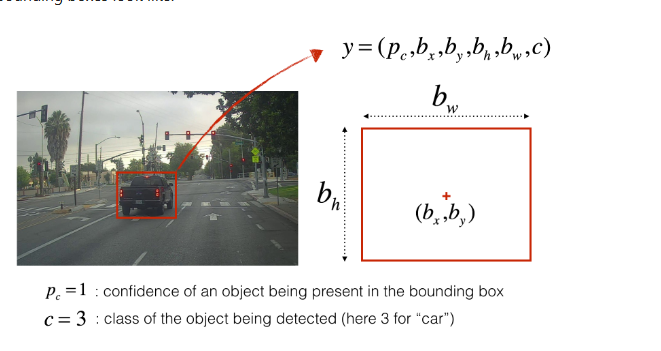

- we will use pretrained model weights of YOLO

### YOLO "You Only Look Once" 

- as it only requires one forward propagaion pass through the network to make predictions. After non-max supression, it then outputs recognized objects together with the bounding boxes.

#### 2.1 Model details

1. Inputs and Outputs
2. Anchor Boxes
3. Encoding

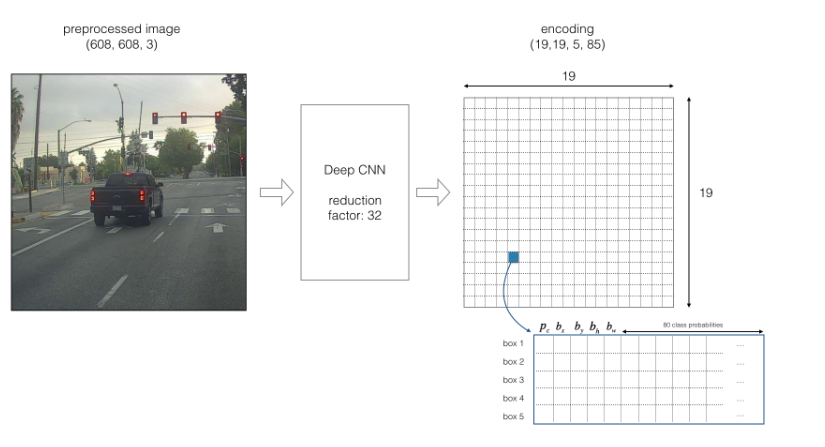

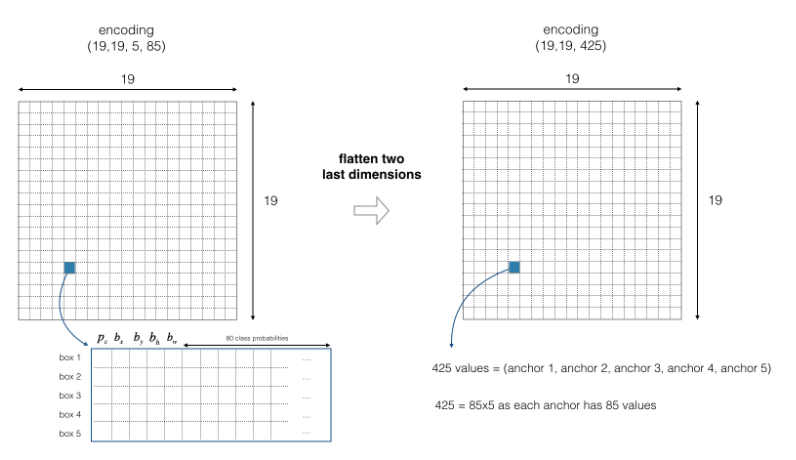

- flattened the last two dimensions.


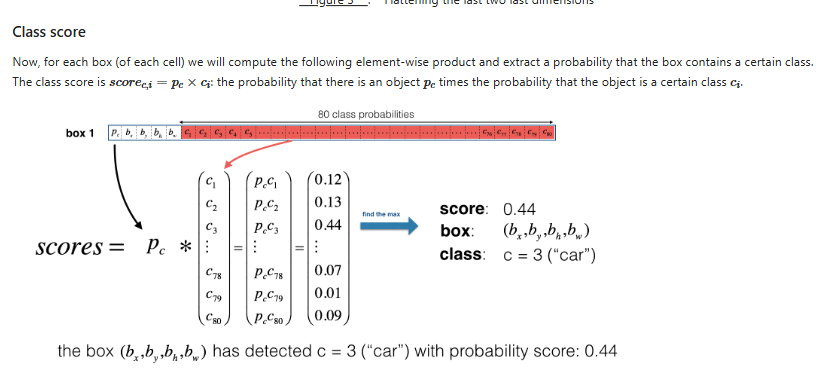

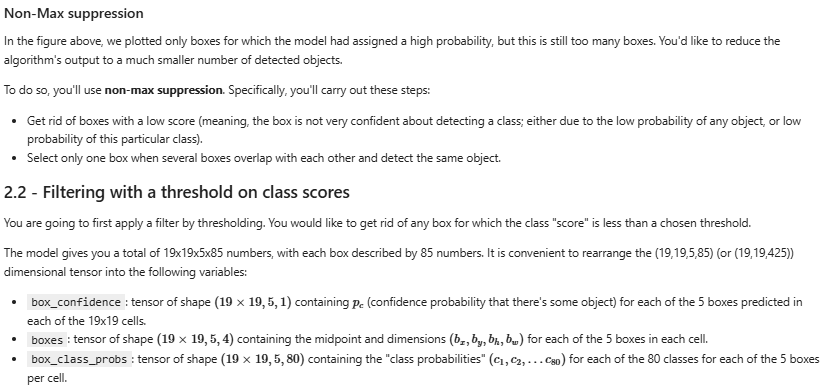

In [2]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold=0.6):

    box_scores = box_confidence * box_class_probs
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)

    filtering_mask = box_class_scores >= threshold

    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)

    return scores, boxes, classes


In [3]:
with tf.compat.v1.Session() as test_a:
    box_confidence = tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed=1)
    boxes = tf.random.normal([19, 19, 5, 4], mean=1, stddev=4, seed=1)
    box_class_probs = tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed=1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold=0.5)
    print("scores[2] = " + str(test_a.run(scores)[2]))
    print("boxes[2] = " + str(test_a.run(boxes)[2]))
    print("classes[2] = " + str(test_a.run(classes)[2]))
    print("scores.shape = " + str(test_a.run(scores).shape))
    print("boxes.shape = " + str(test_a.run(boxes).shape))
    print("classes.shape = " + str(test_a.run(classes).shape))





scores[2] = 10.750582
boxes[2] = [ 8.426533   3.2713668 -0.5313436 -4.9413733]
classes[2] = 7
scores.shape = (1783,)
boxes.shape = (1785, 4)
classes.shape = (1781,)


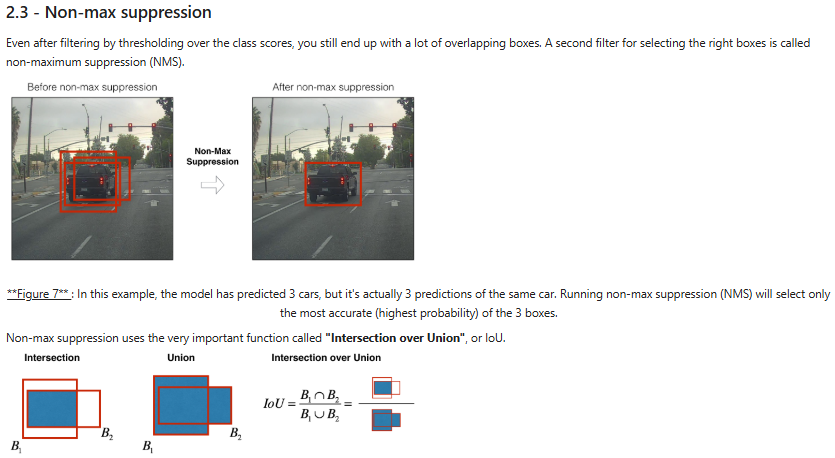

In [4]:
def iou(box1, box2):

    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2

    xi1 = max(box1_x1, box2_x1)
    yi1 = max(box1_y1, box2_y1)
    xi2 = min(box1_x2, box2_x2)
    yi2 = min(box1_y2, box2_y2)

    inter_width = max(xi2 - xi1, 0)
    inter_height = max(yi2 - yi1, 0)
    inter_area = inter_width * inter_height

    # now union area is Union(a, b) = a + b + Inter(a, b)
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area
    
    return iou

In [5]:
# let's test
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4)
print("iou for intersecting boxes = " + str(iou(box1, box2)))

# boxes do not intersect
box1 = (1,2,3,4)
box2 = (5,6,7,8)
print("iou for non-intersecting boxes = " + str(iou(box1,box2)))

# boxes intersect at vertices only
box1 = (1,1,2,2)
box2 = (2,2,3,3)
print("iou for boxes that only touch at vertices = " + str(iou(box1,box2)))

# boxes intersect at edge only
box1 = (1,1,3,3)
box2 = (2,3,3,4)
print("iou for boxes that only touch at edges = " + str(iou(box1,box2)))

iou for intersecting boxes = 0.14285714285714285
iou for non-intersecting boxes = 0.0
iou for boxes that only touch at vertices = 0.0
iou for boxes that only touch at edges = 0.0


In [6]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes=10, iou_threshold=0.5):

    max_boxes_tensor = tf.constant(max_boxes, dtype=tf.int32)

    selected_indices = tf.image.non_max_suppression(
        boxes, scores, max_boxes, iou_threshold
    )

    scores = tf.gather(scores, selected_indices)
    boxes = tf.gather(boxes, selected_indices)
    classes = tf.gather(classes, selected_indices)

    return scores, boxes, classes


In [7]:
with tf.compat.v1.Session() as test_b:
    scores = tf.random.normal([54], mean=1, stddev=4, seed=1)
    boxes = tf.random.normal([54, 4], mean=1, stddev=4, seed=1)
    classes = tf.random.normal([54,], mean=1, stddev=4, seed=1)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    print("scores[2] = " + str(test_b.run(scores)[2]))
    print("boxes[2] = " + str(test_b.run(boxes)[2]))
    print("classes[2] = " + str(test_b.run(classes)[2]))
    print("scores.shape = " + str(test_b.run(scores).shape))
    print("boxes.shape = " + str(test_b.run(boxes).shape))
    print("classes.shape = " + str(test_b.run(classes).shape))





scores[2] = 6.938395
boxes[2] = [-5.299932    3.1379814   4.450367    0.95942086]
classes[2] = -2.2452729
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


#### 2.4 Wrapping up the filtering


In [8]:
def yolo_eval(yolo_outputs,
              image_shape=(720., 1280.),
              max_boxes=10,
              score_threshold=0.6,
              iou_threshold=0.5):

    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    scores, boxes, classes = yolo_filter_boxes(
        box_confidence, boxes, box_class_probs, threshold=score_threshold
    )

    boxes = scale_boxes(boxes, image_shape)

    scores, boxes, classes = yolo_non_max_suppression(
        scores, boxes, classes, max_boxes, iou_threshold
    )

    return scores, boxes, classes

In [9]:
with tf.compat.v1.Session() as test_a:
    yolo_outputs = (tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed=1),
                    tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed=1),
                    tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed=1),
                    tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed=1))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    print("scores[2] = " + str(test_a.run(scores)[2]))
    print("boxes[2] = " + str(test_a.run(boxes)[2]))
    print("classes[2] = " + str(test_a.run(classes)[2]))
    print("scores.shape = " + str(test_a.run(scores).shape))
    print("boxes.shape = " + str(test_a.run(boxes).shape))
    print("classes.shape = " + str(test_a.run(classes).shape))




scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


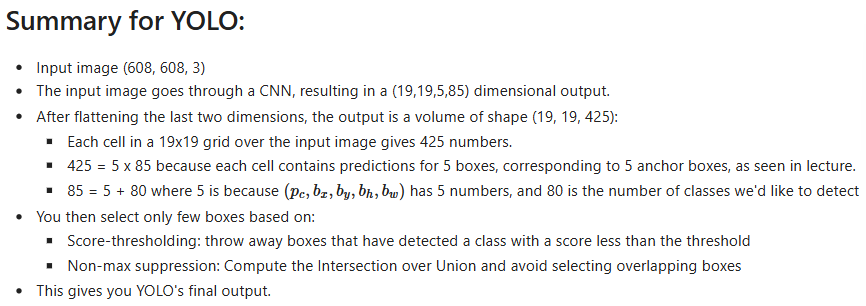

### 3. Test yolo pre-trained model on images

#### 3.1 Defining classes, anchors and image shape

In [10]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)

#### 3.2 Loading a pretrained model

In [11]:
yolo_model = load_model("model_data/yolo.h5")


c:\python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [12]:
# yolo_model.summary()

#### 3.3 - Convert output of the model to usable bounding box tensors

In [13]:
from tensorflow.keras.layers import Layer

class YoloHeadLayer(Layer):
    def __init__(self, anchors, num_classes, **kwargs):
        super(YoloHeadLayer, self).__init__(**kwargs)
        self.anchors = anchors
        self.num_classes = num_classes

    def call(self, inputs):
        # Calls your fixed yolo_head function
        return yolo_head(inputs, self.anchors, self.num_classes)

# Now use this custom layer instead of Lambda
yolo_outputs = YoloHeadLayer(anchors[:3], len(class_names))(yolo_model.output)

#### 3.4 - Filtering boxes

In [14]:
from tensorflow.keras.layers import Layer

class YoloEvalLayer(Layer):
    def __init__(self, image_shape, max_boxes=10, score_threshold=0.6, iou_threshold=0.5, **kwargs):
        super(YoloEvalLayer, self).__init__(**kwargs)
        self.image_shape = image_shape
        self.max_boxes = max_boxes
        self.score_threshold = score_threshold
        self.iou_threshold = iou_threshold

    def call(self, inputs):
        # Calls the existing yolo_eval function within the Layer context
        return yolo_eval(inputs, self.image_shape, self.max_boxes, self.score_threshold, self.iou_threshold)

# Execute the layer
scores, boxes, classes = YoloEvalLayer(image_shape)(yolo_outputs)

#### 3.5 - Run the graph on an image

In [22]:
def predict(image_file):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    can handle both JPG and PNG (4 channels [red, green, blue, Alpha/Transparency]) images
    """
    # Create the output directory if it doesn't exist
    if not os.path.exists("out"):
        os.makedirs("out")

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    # --- FIX FOR PNG IMAGES (RGBA -> RGB) ---
    # If the image has 4 channels (RGBA), drop the alpha channel to make it 3 (RGB)
    if image_data.shape[-1] == 4:
        image_data = image_data[..., :3]
    # ----------------------------------------

    # Check for model existence
    if 'yolo_inference_model' not in globals():
         yolo_inference_model = tf.keras.Model(inputs=yolo_model.input, outputs=[scores, boxes, classes])

    out_scores, out_boxes, out_classes = yolo_inference_model.predict(image_data)

    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    
    colors = generate_colors(class_names)
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    
    # Display the results in the notebook
    output_image = plt.imread(os.path.join("out", image_file))
    plt.imshow(output_image)
    plt.show()
    
    return out_scores, out_boxes, out_classes

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Found 1 boxes for profile_iamge_pic.jpg
person 1.00 (np.int32(233), 0) (524, 498)


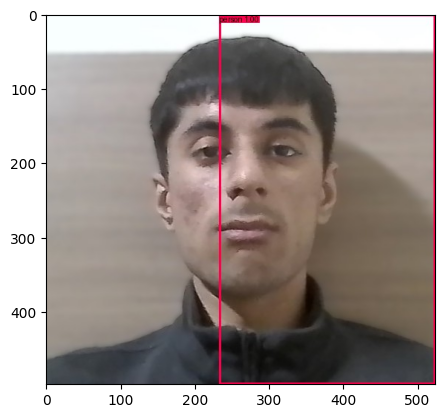

In [18]:
out_scores, out_boxes, out_classes = predict("profile_iamge_pic.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Found 1 boxes for img1.jpg
person 0.95 (np.int32(162), np.int32(84)) (np.int32(575), np.int32(567))


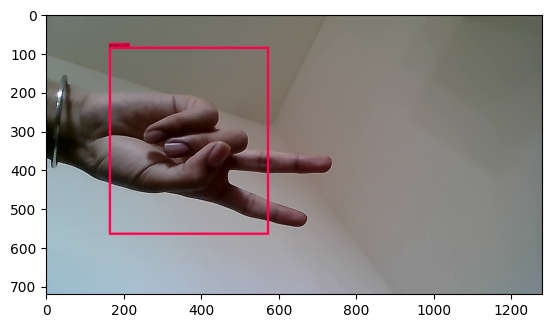

In [19]:
out_scores, out_boxes, out_classes = predict("img1.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Found 0 boxes for HappyModel.png


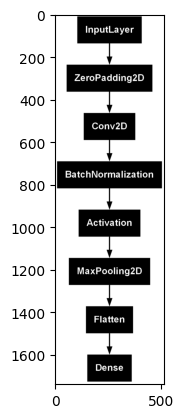

In [23]:
out_scores, out_boxes, out_classes = predict("HappyModel.png")

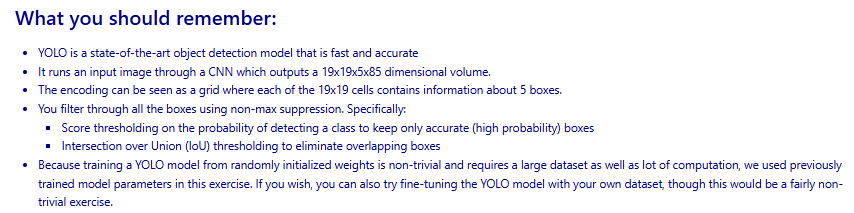

## Finish.
